# Part 1. Data Extraction

In [ ]:
#credits to Allen Wang https://github.com/allenfrostline

In [11]:
from builtins import str
import os
from tarfile import TarFile
import re
import codecs
import json
import pandas as pd
import numpy as np
import holdem_calc

In [12]:
hands = []
with open(r'C:\Users\AZhang\Desktop\hands.json') as file:
    for line in file:
        hands.append(json.loads(line))

In [13]:
hands

[{'_id': 'C:/Users/Aaron Zhang/Desktop/holdem_199504_797210868',
  'game': 'C:/Users/Aaron Zhang/Desktop/holdem',
  'dealer': 1,
  'hand_num': 192,
  'num_players': 9,
  'pots': [{'stage': 'f', 'num_players': 2, 'size': 20},
   {'stage': 't', 'num_players': 2, 'size': 40},
   {'stage': 'r', 'num_players': 2, 'size': 80},
   {'stage': 's', 'num_players': 2, 'size': 120}],
  'board': ['Qc', 'Ks', '8s', 'Jh', 'Tc'],
  'players': [{'user': 'Quick',
    'bets': [{'actions': ['Q'], 'stage': 'p'},
     {'actions': ['-'], 'stage': 'f'},
     {'actions': ['-'], 'stage': 't'},
     {'actions': ['-'], 'stage': 'r'}],
    'bankroll': 885,
    'action': 0,
    'winnings': 0,
    'pocket_cards': [],
    'pos': 7},
   {'user': 'Winner777',
    'bets': [{'actions': ['f'], 'stage': 'p'},
     {'actions': ['-'], 'stage': 'f'},
     {'actions': ['-'], 'stage': 't'},
     {'actions': ['-'], 'stage': 'r'}],
    'bankroll': 1255,
    'action': 0,
    'winnings': 0,
    'pocket_cards': [],
    'pos': 3},
   

In [238]:
hands_df = pd.DataFrame(columns=['index','hand_num','big_blind','player','pos','bankroll','preflop_equity','preflop_rank',
                        'preflop_action','preflop_pot','flop_equity','flop_action','flop_pot','turn_equity',
                        'turn_action','turn_pot','river_equity','river_action','river_pot','earnings'])

hands_df

,index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,preflop_action,preflop_pot,flop_equity,flop_action,flop_pot,turn_equity,turn_action,turn_pot,river_equity,river_action,river_pot,earnings


# Part 2. Data Rebuilding into Pandas

In [4]:
#not in pot: F,Q, K 
#k is call
#no pocket cards for ppl who folded
#user: hands[i]['players'][j]['user']
#bets: hands[i]['players'][j]['bets'][0]['actions']
#preflop action: hands[i]['players'][j]['bets'][0]['actions'][0]

In [5]:
hands[0]['players'][4]

{'user': 'gunner',
 'bets': [{'actions': ['c'], 'stage': 'p'},
  {'actions': ['c'], 'stage': 'f'},
  {'actions': ['c'], 'stage': 't'},
  {'actions': ['b'], 'stage': 'r'}],
 'bankroll': 785,
 'action': 60,
 'winnings': 120,
 'pocket_cards': ['8h', 'Ad'],
 'pos': 9}

In [12]:
#data to input into dataframe: i denoting the hand
#hand_num: hands[i]['hand_num']
#big_blind: 10 or 20 *brainstorm how to determine if its 10 or 20
#player: the same logic as in_play_dict; hands[i]['players'][j]['user']
#pos: using checking if in_play,hands[i]['players'][j]['pos']
#bankroll: check, then hands[i]['players'][j]['bankroll']
#preflop_equity: holdem_calc.calculate(None, exact_calculation, num_sims, None , hole_cards, None)[1,2,3,etc] *
#preflop_rank: self_constructed
#preflop_action: hands[i]['players'][j]['bets'][0]['actions']
#preflop_pot: hands[i]['pots'][0]['size']/hands[i]['pots'][0]['num_players']
#flop_equity: holdem_calc.calculate(flop, exact_calculation, num_sims, None , hole_cards, None)[1,2,3,etc] *
#flop_action: hands[i]['players'][j]['bets'][1]['actions']
#flop_pot: hands[i]['pots'][1]['size']/hands[i]['pots'][1]['num_players']
#turn_equity: holdem_calc.calculate(turn, exact_calculation, num_sims, None , hole_cards, None)[1,2,3,etc] *
#turn_action: hands[i]['players'][j]['bets'][2]['actions']
#turn_pot: hands[i]['pots'][2]['size']/hands[i]['pots'][2]['num_players']
#river_equity:holdem_calc.calculate(river, exact_calculation, num_sims, None , hole_cards, None)[1,2,3,etc] *
#river_action: hands[i]['players'][j]['bets'][3]['actions']
#river_pot: hands[i]['pots'][3]['size']/hands[i]['pots'][3]['num_players']
#earnings: hands[i]['players'][4]['winnings'] - hands[i]['players'][4]['action']
exact_calculation = False
num_sims = 10000
test_list = [hands[0]['hand_num'],10,hands[0]['players'][4]['user'],hands[0]['players'][4]['pos'],
            hands[0]['players'][4]['bankroll'],
            holdem_calc.calculate(None, exact_calculation, num_sims, None , hole_cards, None)[1],2,
            hands[0]['players'][4]['bets'][0]['actions'],hands[0]['pots'][0]['size']/hands[0]['pots'][0]['num_players'],
            holdem_calc.calculate(flop, exact_calculation, num_sims, None , hole_cards, None)[1],
            hands[0]['players'][4]['bets'][1]['actions'],hands[0]['pots'][1]['size']-hands[0]['pots'][0]['size']/hands[0]['pots'][1]['num_players'],
            holdem_calc.calculate(turn, exact_calculation, num_sims, None , hole_cards, None)[1],
            hands[0]['players'][4]['bets'][2]['actions'],hands[0]['pots'][2]['size']-hands[0]['pots'][1]['size']/hands[0]['pots'][2]['num_players'],
            holdem_calc.calculate(river, exact_calculation, num_sims, None , hole_cards, None)[1],
            hands[0]['players'][4]['bets'][3]['actions'],hands[0]['pots'][3]['size']-hands[0]['pots'][2]['size']/hands[0]['pots'][3]['num_players'],
            hands[0]['players'][4]['winnings'] - hands[0]['players'][4]['action']]

In [239]:
flop = hands[0]['board'][0:3] # the flop
turn = hands[0]['board'][0:4]
river = hands[0]['board'][0:5]
#flop = None
board = ['f','t','r','s'] # the board equals the flop
hole_cards = [element for sublist in in_play_dict.values() for element in sublist]
exact_calculation = False #  calculates exactly by simulating the set of all possible hands
verbose = True # returns odds of making a certain poker hand, e.g., quads, set, straight
num_sims = 1000 # ignored by exact_calculation = True
read_from_file = None # we are not reading hands from file


odds = holdem_calc.calculate(flop, exact_calculation, num_sims, read_from_file , hole_cards, None)

In [103]:
#testing dataframe layout
hands_df = hands_df.drop(0,axis=0)
hands_df

,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,preflop_action,preflop_pot,flop_equity,flop_action,flop_pot,turn_equity,turn_action,turn_pot,river_equity,river_action,river_pot,earnings


In [24]:
#check action function
def check_action(board):
    action_id = []
    
    for i in range(len(board['players'])):
        if board['players'][i]['pocket_cards']:
            action_id.append(i)
    return action_id
check_action(hands[0])

[4, 7]

In [36]:
#check preflop function, when someone wins on preflop and pocket cards not shown; postflop, pocket cards registered and can
#be caught be check_action function

exit_hand = ['Q','f','K']

def check_preflop(board):
    action_id = []
    
    for i in range(len(board['players'])):
        if board['players'][i]['bets'][0]['actions'][0] not in exit_hand:
            action_id.append(i)
    return action_id

check_preflop(hands[0])

[4, 7]

In [39]:
#['hand_num','big_blind','player','pos','bankroll','preflop_equity','preflop_rank',
#'preflop_action','preflop_pot','flop_equity','flop_action','flop_pot','turn_equity',
#'turn_action','turn_pot','river_equity','river_action','river_pot','earnings']

#if win on preflop, registered as showdown; but pocket cards not shown

120

In [240]:
for k in range(len(hands)):
    #check board state to ensure we're not overindexing
    #hand numbers not unique!!!!
    #division by zero error most likely thrown by all in action
    #one more issue is that between those not in HU action, a fold postflop would mess up pot calculations
    #also run into issue of raise/fold actions that inflate the size of the poteven in HU action
    #first issue solved through looking at either action integer or at _action last if it is a fold, then deduct
    #this method should be doable through an application of a function to the created dataframe
    #second issue more complex
    #more issues: missing data, no KQf exit, somehow player directly vanishes into thin air prior to river but 
    #board still shows five cards
    #hands[k]['players'][current_players[i]]['bets'][3]
    index = k
    
    flag = False
    
    if len(hands[k]['board']) == 5:
        for i in range(len(check_action(hands[k]))):
            if len(hands[k]['board']) != len(hands[k]['players'][check_action(hands[k])[i]]['bets']) + 1:
                flag = True
    
    if flag == True:
        print(flag)
        continue
    
    
    if len(hands[k]['board']) == 0:
        for i in range(len(check_preflop(hands[k]))):
            current_players = check_preflop(hands[k])
            player_cards = []

            for a in range(len(current_players)):
                player_cards.append(hands[k]['players'][current_players[a]]['pocket_cards'])

            hole_cards = [element for sublist in player_cards for element in sublist]
            
            hand_num = hands[k]['hand_num']
            big_blind = 10
            player = hands[k]['players'][current_players[i]]['user']
            pos = hands[k]['players'][current_players[i]]['pos']
            bankroll = hands[k]['players'][current_players[i]]['bankroll']
            preflop_equity = None
            preflop_rank = None
            preflop_action = hands[k]['players'][current_players[i]]['bets'][0]['actions']
            preflop_pot = hands[k]['pots'][3]['size']
            flop_equity = None
            flop_action = None
            flop_pot = None
            turn_equity = None
            turn_action = None
            turn_pot = None
            river_equity = None
            river_action = None
            river_pot = None
            earnings = hands[k]['players'][current_players[i]]['winnings'] - hands[k]['players'][current_players[i]]['action']
            
            hand_stats = [index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,
                    preflop_action,preflop_pot,flop_equity,flop_action,flop_pot,turn_equity,
                    turn_action,turn_pot,river_equity,river_action,river_pot,earnings]
        
            hands_df.loc[len(hands_df)] = hand_stats
    elif len(hands[k]['board']) == 3:
        for i in range(len(check_action(hands[k]))):
            flop = hands[k]['board'][0:3]

            current_players = check_action(hands[k])
            player_cards = []

            for a in range(len(current_players)):
                player_cards.append(hands[k]['players'][current_players[a]]['pocket_cards'])

            hole_cards = [element for sublist in player_cards for element in sublist]
            hand_num = hands[k]['hand_num']
            big_blind = 10
            player = hands[k]['players'][current_players[i]]['user']
            pos = hands[k]['players'][current_players[i]]['pos']
            bankroll = hands[k]['players'][current_players[i]]['bankroll']
            preflop_equity = holdem_calc.calculate(None, exact_calculation, num_sims, None , hole_cards, None)[i+1]
            preflop_rank = 'preflop rank'
            preflop_action = hands[k]['players'][current_players[i]]['bets'][0]['actions']
            preflop_pot = hands[k]['pots'][0]['size']/hands[k]['pots'][0]['num_players']
            flop_equity = holdem_calc.calculate(flop, exact_calculation, num_sims, None , hole_cards, None)[i+1]
            flop_action = hands[k]['players'][current_players[i]]['bets'][1]['actions']
            flop_pot = (hands[k]['pots'][1]['size']-hands[k]['pots'][0]['size'])/hands[k]['pots'][1]['num_players']
            turn_equity = None
            turn_action = None
            turn_pot = None
            river_equity = None
            river_action = None
            river_pot = None
            earnings = hands[k]['players'][current_players[i]]['winnings'] - hands[k]['players'][current_players[i]]['action']
            
            hand_stats = [index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,
                    preflop_action,preflop_pot,flop_equity,flop_action,flop_pot,turn_equity,
                    turn_action,turn_pot,river_equity,river_action,river_pot,earnings]
        
            hands_df.loc[len(hands_df)] = hand_stats
    elif len(hands[k]['board']) == 4:
        for i in range(len(check_action(hands[k]))):
            flop = hands[k]['board'][0:3]
            turn = hands[k]['board'][0:4]

            current_players = check_action(hands[k])
            player_cards = []

            for a in range(len(current_players)):
                player_cards.append(hands[k]['players'][current_players[a]]['pocket_cards'])

            hole_cards = [element for sublist in player_cards for element in sublist]
            hand_num = hands[k]['hand_num']
            big_blind = 10
            player = hands[k]['players'][current_players[i]]['user']
            pos = hands[k]['players'][current_players[i]]['pos']
            bankroll = hands[k]['players'][current_players[i]]['bankroll']
            preflop_equity = holdem_calc.calculate(None, exact_calculation, num_sims, None , hole_cards, None)[i+1]
            preflop_rank = 'preflop rank'
            preflop_action = hands[k]['players'][current_players[i]]['bets'][0]['actions']
            preflop_pot = hands[k]['pots'][0]['size']/hands[k]['pots'][0]['num_players']
            flop_equity = holdem_calc.calculate(flop, exact_calculation, num_sims, None , hole_cards, None)[i+1]
            flop_action = hands[k]['players'][current_players[i]]['bets'][1]['actions']
            flop_pot = (hands[k]['pots'][1]['size']-hands[k]['pots'][0]['size'])/hands[k]['pots'][1]['num_players']
            turn_equity = holdem_calc.calculate(turn, exact_calculation, num_sims, None , hole_cards, None)[i+1]
            turn_action = hands[k]['players'][current_players[i]]['bets'][2]['actions']
            turn_pot = (hands[k]['pots'][2]['size']-hands[k]['pots'][1]['size'])/hands[k]['pots'][2]['num_players']
            river_equity = None
            river_action = None
            river_pot = None
            earnings = hands[k]['players'][current_players[i]]['winnings'] - hands[k]['players'][current_players[i]]['action']
            
            hand_stats = [index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,
                    preflop_action,preflop_pot,flop_equity,flop_action,flop_pot,turn_equity,
                    turn_action,turn_pot,river_equity,river_action,river_pot,earnings]
        
            hands_df.loc[len(hands_df)] = hand_stats
    elif len(hands[k]['board']) == 5: 
        #all in catcher; needs to consider all in at different times
        if (hands[k]['pots'][0]['size'] == 0 and hands[k]['pots'][1]['size'] == 0):
            #all in preflop
            for i in range(len(check_action(hands[k]))):
                flop = hands[k]['board'][0:3]
                turn = hands[k]['board'][0:4]
                river = hands[k]['board'][0:5]

                current_players = check_action(hands[k])
                player_cards = []

                for a in range(len(current_players)):
                    player_cards.append(hands[k]['players'][current_players[a]]['pocket_cards'])

                hole_cards = [element for sublist in player_cards for element in sublist]
                
                if hands[k]['pots'][3]['num_players'] == 0:
                    #quit catcher
                    preflop_pot = hands[k]['pots'][3]['size']/hands[k]['pots'][2]['num_players']
                else:
                    preflop_pot = hands[k]['pots'][3]['size']/hands[k]['pots'][3]['num_players']
                
                hand_num = hands[k]['hand_num']
                big_blind = 10
                player = hands[k]['players'][current_players[i]]['user']
                pos = hands[k]['players'][current_players[i]]['pos']
                bankroll = hands[k]['players'][current_players[i]]['bankroll']
                preflop_equity = holdem_calc.calculate(None, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                preflop_rank = 'preflop rank'
                preflop_action = hands[k]['players'][current_players[i]]['bets'][0]['actions']
                flop_equity = holdem_calc.calculate(flop, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                flop_action = None
                flop_pot = preflop_pot
                turn_equity = holdem_calc.calculate(turn, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                turn_action = None
                turn_pot = preflop_pot
                river_equity = holdem_calc.calculate(river, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                river_action = None
                river_pot = preflop_pot
                earnings = hands[k]['players'][current_players[i]]['winnings'] - hands[k]['players'][current_players[i]]['action']

                hand_stats = [index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,
                        preflop_action,preflop_pot,flop_equity,flop_action,flop_pot,turn_equity,
                        turn_action,turn_pot,river_equity,river_action,river_pot,earnings]

                hands_df.loc[len(hands_df)] = hand_stats
        elif (hands[k]['pots'][0]['size'] != 0 and hands[k]['pots'][1]['size'] == 0):
            #all in flop
            for i in range(len(check_action(hands[k]))):
                flop = hands[k]['board'][0:3]
                turn = hands[k]['board'][0:4]
                river = hands[k]['board'][0:5]

                current_players = check_action(hands[k])
                player_cards = []

                for a in range(len(current_players)):
                    player_cards.append(hands[k]['players'][current_players[a]]['pocket_cards'])

                hole_cards = [element for sublist in player_cards for element in sublist]
                hand_num = hands[k]['hand_num']
                big_blind = 10
                player = hands[k]['players'][current_players[i]]['user']
                pos = hands[k]['players'][current_players[i]]['pos']
                bankroll = hands[k]['players'][current_players[i]]['bankroll']
                preflop_equity = holdem_calc.calculate(None, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                preflop_rank = 'preflop rank'
                preflop_action = hands[k]['players'][current_players[i]]['bets'][0]['actions']
                preflop_pot = hands[k]['pots'][0]['size']/hands[k]['pots'][0]['num_players']
                flop_equity = holdem_calc.calculate(flop, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                flop_action = hands[k]['players'][current_players[i]]['bets'][1]['actions']
                
                if hands[k]['pots'][3]['num_players'] == 0:
                    #quit catcher
                    flop_pot = (hands[k]['pots'][2]['size']-hands[k]['pots'][0]['size'])/hands[k]['pots'][2]['num_players']
                else:
                    flop_pot = (hands[k]['pots'][3]['size']-hands[k]['pots'][0]['size'])/hands[k]['pots'][3]['num_players']

                turn_equity = holdem_calc.calculate(turn, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                turn_action = None
                turn_pot = flop_pot
                river_equity = holdem_calc.calculate(river, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                river_action = None
                river_pot = flop_pot
                earnings = hands[k]['players'][current_players[i]]['winnings'] - hands[k]['players'][current_players[i]]['action']

                hand_stats = [index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,
                        preflop_action,preflop_pot,flop_equity,flop_action,flop_pot,turn_equity,
                        turn_action,turn_pot,river_equity,river_action,river_pot,earnings]

                hands_df.loc[len(hands_df)] = hand_stats
        elif (hands[k]['pots'][0]['size'] != 0 and hands[k]['pots'][1]['size'] != 0 and hands[k]['pots'][2]['size'] == 0):
            #all in turn
            for i in range(len(check_action(hands[k]))):
                flop = hands[k]['board'][0:3]
                turn = hands[k]['board'][0:4]
                river = hands[k]['board'][0:5]

                current_players = check_action(hands[k])
                player_cards = []

                for a in range(len(current_players)):
                    player_cards.append(hands[k]['players'][current_players[a]]['pocket_cards'])

                hole_cards = [element for sublist in player_cards for element in sublist]
                hand_num = hands[k]['hand_num']
                big_blind = 10
                player = hands[k]['players'][current_players[i]]['user']
                pos = hands[k]['players'][current_players[i]]['pos']
                bankroll = hands[k]['players'][current_players[i]]['bankroll']
                preflop_equity = holdem_calc.calculate(None, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                preflop_rank = 'preflop rank'
                preflop_action = hands[k]['players'][current_players[i]]['bets'][0]['actions']
                preflop_pot = hands[k]['pots'][0]['size']/hands[k]['pots'][0]['num_players']
                flop_equity = holdem_calc.calculate(flop, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                flop_action = hands[k]['players'][current_players[i]]['bets'][1]['actions']
                flop_pot = (hands[k]['pots'][1]['size']-hands[k]['pots'][0]['size'])/hands[k]['pots'][1]['num_players']
                turn_equity = holdem_calc.calculate(turn, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                turn_action = hands[k]['players'][current_players[i]]['bets'][2]['actions']
                
                if hands[k]['pots'][3]['num_players'] == 0:
                    #quit catcher
                    flop_pot = (hands[k]['pots'][3]['size']-hands[k]['pots'][1]['size'])/hands[k]['pots'][1]['num_players']
                else:
                    flop_pot = (hands[k]['pots'][3]['size']-hands[k]['pots'][1]['size'])/hands[k]['pots'][3]['num_players']
                
                turn_pot = (hands[k]['pots'][3]['size']-hands[k]['pots'][1]['size'])/hands[k]['pots'][3]['num_players']
                river_equity = holdem_calc.calculate(river, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                river_action = None
                river_pot = turn_pot
                earnings = hands[k]['players'][current_players[i]]['winnings'] - hands[k]['players'][current_players[i]]['action']

                hand_stats = [index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,
                        preflop_action,preflop_pot,flop_equity,flop_action,flop_pot,turn_equity,
                        turn_action,turn_pot,river_equity,river_action,river_pot,earnings]

                hands_df.loc[len(hands_df)] = hand_stats
                
        #no need to further consider all in river, as river all in can be caught as just bet
        else:
            for i in range(len(check_action(hands[k]))):
                flop = hands[k]['board'][0:3]
                turn = hands[k]['board'][0:4]
                river = hands[k]['board'][0:5]

                current_players = check_action(hands[k])
                player_cards = []

                for a in range(len(current_players)):
                    player_cards.append(hands[k]['players'][current_players[a]]['pocket_cards'])

                hole_cards = [element for sublist in player_cards for element in sublist]
                
                
                hand_num = hands[k]['hand_num']
                big_blind = 10
                player = hands[k]['players'][current_players[i]]['user']
                pos = hands[k]['players'][current_players[i]]['pos']
                bankroll = hands[k]['players'][current_players[i]]['bankroll']
                preflop_equity = holdem_calc.calculate(None, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                preflop_rank = 'preflop rank'
                preflop_action = hands[k]['players'][current_players[i]]['bets'][0]['actions']
                preflop_pot = hands[k]['pots'][0]['size']/hands[k]['pots'][0]['num_players']
                flop_equity = holdem_calc.calculate(flop, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                flop_action = hands[k]['players'][current_players[i]]['bets'][1]['actions']
                flop_pot = (hands[k]['pots'][1]['size']-hands[k]['pots'][0]['size'])/hands[k]['pots'][1]['num_players']
                turn_equity = holdem_calc.calculate(turn, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                turn_action = hands[k]['players'][current_players[i]]['bets'][2]['actions']
                turn_pot = (hands[k]['pots'][2]['size']-hands[k]['pots'][1]['size'])/hands[k]['pots'][2]['num_players']
                river_equity = holdem_calc.calculate(river, exact_calculation, num_sims, None , hole_cards, None)[i+1]
                river_action = hands[k]['players'][current_players[i]]['bets'][3]['actions']
                
                if hands[k]['pots'][3]['num_players'] == 0:
                    #quit catcher
                    river_pot = (hands[k]['pots'][3]['size']-hands[k]['pots'][2]['size'])/hands[k]['pots'][2]['num_players']
                else:
                    river_pot = (hands[k]['pots'][3]['size']-hands[k]['pots'][2]['size'])/hands[k]['pots'][3]['num_players']
                    
                earnings = hands[k]['players'][current_players[i]]['winnings'] - hands[k]['players'][current_players[i]]['action']

                hand_stats = [index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,
                        preflop_action,preflop_pot,flop_equity,flop_action,flop_pot,turn_equity,
                        turn_action,turn_pot,river_equity,river_action,river_pot,earnings]

                hands_df.loc[len(hands_df)] = hand_stats


True
True
True
True
True
True
True


In [7]:
complete_df = pd.read_csv(r'C:\Users\AZhang\Desktop\complete_hands_df.csv')
complete_df = complete_df.drop('Unnamed: 0',axis=1)

In [8]:
complete_df

,index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,preflop_action,preflop_pot,flop_equity,flop_action,flop_pot,turn_equity,turn_action,turn_pot,river_equity,river_action,river_pot,earnings
0,0,192,10,gunner,9,785,0.559,preflop rank,['c'],10.000000,0.202020,['c'],10.0,0.204545,['c'],20.0,1.0,['b'],20.0,60
1,0,192,10,sagerbot,1,1740,0.402,preflop rank,"['B', 'k']",10.000000,0.797980,['b'],10.0,0.795455,['b'],20.0,0.0,"['k', 'c']",20.0,-60
2,1,193,10,Winner777,3,1255,0.661,preflop rank,['r'],23.333333,0.973737,['b'],10.0,0.954545,['b'],20.0,1.0,"['b', 'c']",40.0,120
3,1,193,10,shinner,6,855,0.230,preflop rank,['c'],23.333333,0.021212,['c'],10.0,0.000000,['c'],20.0,0.0,['r'],40.0,-90
4,2,194,10,deadhead,6,1000,0.891,preflop rank,['r'],25.000000,0.833333,['b'],10.0,0.909091,['b'],20.0,1.0,['b'],20.0,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360489,277605,31210,10,num,1,1810,NaN,NaN,"['B', 'f']",15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5
360490,277606,31211,10,kman,1,21401,NaN,NaN,"['B', 'r']",30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
360491,277606,31211,10,num,2,1805,NaN,NaN,"['B', 'f']",30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10
360492,277607,31212,10,kman,2,21411,NaN,NaN,['B'],15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [14]:
def pocket_cards(index,player):
    if len(hands[index]['board']) == 0:
        return []
    else:
        for i in range(len(hands[index]['players'])):
            if hands[index]['players'][i]['user'] == player:
                return hands[index]['players'][i]['pocket_cards']

#hands[k]['players'][current_players[a]]['pocket_cards']

In [15]:
complete_df['pocket_cards'] = complete_df.apply(lambda x: pocket_cards(x['index'], x['player']), axis=1) 

# Part 3. Data Cleaning and Processing

Once DataFrame loading is complete, things to figure out:

3. ensuring that betting/folding especially in non HU does not miscalculate;also difficult to judge

In general, bet sizing will be hard to sort out, general statistics can be used but results might be really screwed


In [4]:
hand_rankings = {
    'AAo':1,
    'KKo':2,
    'QQo':3,
    'AKs':4,
    'JJo':5,
    'AQs':6,
    'KQs':7,
    'AJs':8,
    'KJs':9,
    'TTo':10,
    'AKo':11,
    'ATs':12,
    'QJs':13,
    'KTs':14,
    'QTs':15,
    'JTs':16,
    '99o':17,
    'AQo':18,
    'A9s':19,
    'KQo':20,
    '88o':21,
    'K9s':22,
    'T9s':23,
    'A8s':24,
    'Q9s':25,
    'J9s':26,
    'AJo':27,
    'A5s':28,
    '77o':29,
    'A7s':30,
    'KJo':31,
    'A4s':32,
    'A3s':33,
    'A6s':34,
    'QJo':35,
    '66o':36,
    'K8s':37,
    'T8s':38,
    'A2s':39,
    '98s':40,
    'J8s':41,
    'ATo':42,
    'Q8s':43,
    'K7s':44,
    'KTo':45,
    '55o':46,
    'JTo':47,
    '87s':48,
    'QTo':49,
    '44o':50,
    '33o':51,
    '22o':52,
    'K6s':53,
    '97s':54,
    'K5s':55,
    '76s':56,
    'T7s':57,
    'K4s':58,
    'K3s':59,
    'K2s':60,
    'Q7s':61,
    '86s':62,
    '65s':63,
    'J7s':64,
    '54s':65,
    'Q6s':66,
    '75s':67,
    '96s':68,
    'Q5s':69,
    '64s':70,
    'Q4s':71,
    'Q3s':72,
    'T9o':73,
    'T6s':74,
    'Q2s':75,
    'A9o':76,
    '53s':77,
    '85s':78,
    'J6s':79,
    'J9o':80,
    'K9o':81,
    'J5s':82,
    'Q9o':83,
    '43s':84,
    '74s':85,
    'J4s':86,
    'J3s':87,
    '95s':88,
    'J2s':89,
    '63s':90,
    'A8o':91,
    '52s':92,
    'T5s':93,
    '84s':94,
    'T4s':95,
    'T3s':96,
    '42s':97,
    'T2s':98,
    '98o':99,
    'T8o':100,
    'A5o':101,
    'A7o':102,
    '73s':103,
    'A4o':104,
    '32s':105,
    '94s':106,
    '93s':107,
    'J8o':108,
    'A3o':109,
    '62s':110,
    '92s':111,
    'K8o':112,
    'A6o':113,
    '87o':114,
    'Q8o':115,
    '83s':116,
    'A2o':117,
    '82s':118,
    '97o':119,
    '72s':120,
    '76o':121,
    'K7o':122,
    '65o':123,
    'T7o':124,
    'K6o':125,
    '86o':126,
    '54o':127,
    'K5o':128,
    'J7o':129,
    '75o':130,
    'Q7o':131,
    'K4o':132,
    'K3o':133,
    '96o':134,
    'K2o':135,
    '64o':136,
    'Q6o':137,
    '53o':138,
    '85o':139,
    'T6o':140,
    'Q5o':141,
    '43o':142,
    'Q4o':143,
    'Q3o':144,
    '74o':145,
    'Q2o':146,
    'J6o':147,
    '63o':148,
    'J5o':149,
    '95o':150,
    '52o':151,
    'J4o':152,
    'J3o':153,
    '42o':154,
    'J2o':155,
    '84o':156,
    'T5o':157,
    'T4o':158,
    '32o':159,
    'T3o':160,
    '73o':161,
    'T2o':162,
    '62o':163,
    '94o':164,
    '93o':165,
    '92o':166,
    '83o':167,
    '82o':168,
    '72o':169  
}
#no hand is -1

In [17]:
value = ["2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K",'A'] #list of card values

def compare(card1, card2):
     """
     Compares the value of two cards and returns the greater of the two
     :param card1: A card object
     :param card2: A second card object
     :return: The higher value card, if tie returns 0
     """
     if value.index(card1) > value.index(card2):
         return card1
     elif value.index(card1) == value.index(card2):
         return 0
     else:
         return card2

def rank_hand(hand):
    if len(hand) == 0:
        return None
    
    hand_str = hand[0] + hand[1]
    
    if hand_str[1] != hand_str[3]:
        if compare(hand_str[0],hand_str[2]) == 0:
            temp_hand = hand_str[0] + hand_str[2] + 'o'
        elif compare(hand_str[0],hand_str[2]) == hand_str[0]:
            temp_hand = hand_str[0] + hand_str[2] + 'o'
        else:
            temp_hand = hand_str[2] + hand_str[0] + 'o'
    else:
        if compare(hand_str[0],hand_str[2]) == 0:
            temp_hand = hand_str[0] + hand_str[2] + 's'
        elif compare(hand_str[0],hand_str[2]) == hand_str[0]:
            temp_hand = hand_str[0] + hand_str[2] + 's'
        else:
            temp_hand = hand_str[2] + hand_str[0] + 's'
    
    #hand can be in any order, need to order hand by big card first
    return hand_rankings[temp_hand]

def action_eval(action_list):
    hyper_aggression = ['A']
    aggression = ['b','r']
    neutral = ['B']
    averse = ['k','c']
    hyper_averse = ['f','K','Q']
    counter = 0
    
    if action_list is None:
        #preflop showdown
        return None
    
    try:
        len(action_list)
    except:
        return None
    
    if (len(action_list) == 1 and action_list[0] == '-'):
        #no action
        return None
    
    for i in range(len(action_list)):
        #everything else
        if action_list[i] in hyper_aggression:
            counter += 2
        elif action_list[i] in aggression:
            counter += 1
        elif action_list[i] in neutral:
            counter += 0
        elif action_list[i] in averse:
            counter -= 1
        elif action_list[i] in hyper_averse:
            counter -= 2
    
    return counter

def blind_eval(preflop_pot,preflop_action):
    big_blind = 0
    
    if preflop_pot is None:
        return None
    
    if preflop_pot.is_integer():
        if preflop_pot < 20:
            big_blind = 10
        elif preflop_pot == 20:
            if len(preflop_action) >= 2:
                big_blind = 10
            else:
                big_blind = 20
        else:
            big_blind = 20
    else:
        number = 0
        if str(preflop_pot).endswith('33'):
            number = np.round(preflop_pot * 3) 
        elif str(preflop_pot).endswith('.25'):
            number = np.round(preflop_pot * 4)
        elif str(preflop_pot).endswith('67'):
            number = np.round(preflop_pot * 3)
        elif str(preflop_pot).endswith('714286'):
            number = np.round(preflop_pot * 7)
        elif str(preflop_pot).endswith('36'):
            number = np.round(preflop_pot * 6)
            
        if number % 20 == 0:
            big_blind = 20
        else:
            big_blind = 10
    return big_blind

In [18]:
#no street action, preflop showdown, no hand detected ---> None
complete_df['preflop_rank'] = complete_df['pocket_cards'].apply(rank_hand) 
complete_df['preflop_cat_action'] = complete_df['preflop_action'].apply(action_eval) 
complete_df['flop_cat_action'] = complete_df['flop_action'].apply(action_eval) 
complete_df['turn_cat_action'] = complete_df['turn_action'].apply(action_eval) 
complete_df['river_cat_action'] = complete_df['river_action'].apply(action_eval)
complete_df['big_blind'] = complete_df.apply(lambda x: blind_eval(x['preflop_pot'], x['preflop_action']), axis=1)

In [19]:
complete_df

,index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,preflop_action,preflop_pot,...,turn_pot,river_equity,river_action,river_pot,earnings,pocket_cards,preflop_cat_action,flop_cat_action,turn_cat_action,river_cat_action
0,0,192,10,gunner,9,785,0.559,91.0,['c'],10.000000,...,20.0,1.0,['b'],20.0,60,"[8h, Ad]",-1,-1.0,-1.0,1.0
1,0,192,10,sagerbot,1,1740,0.402,35.0,"['B', 'k']",10.000000,...,20.0,0.0,"['k', 'c']",20.0,-60,"[Qd, Jc]",-1,1.0,1.0,-2.0
2,1,193,10,Winner777,3,1255,0.661,42.0,['r'],23.333333,...,20.0,1.0,"['b', 'c']",40.0,120,"[Td, Ac]",1,1.0,1.0,0.0
3,1,193,10,shinner,6,855,0.230,91.0,['c'],23.333333,...,20.0,0.0,['r'],40.0,-90,"[As, 8d]",-1,-1.0,-1.0,1.0
4,2,194,20,deadhead,6,1000,0.891,3.0,['r'],25.000000,...,20.0,1.0,['b'],20.0,80,"[Qd, Qc]",1,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360489,277605,31210,10,num,1,1810,NaN,NaN,"['B', 'f']",15.000000,...,NaN,NaN,NaN,NaN,-5,[],-2,NaN,NaN,NaN
360490,277606,31211,20,kman,1,21401,NaN,NaN,"['B', 'r']",30.000000,...,NaN,NaN,NaN,NaN,10,[],1,NaN,NaN,NaN
360491,277606,31211,20,num,2,1805,NaN,NaN,"['B', 'f']",30.000000,...,NaN,NaN,NaN,NaN,-10,[],-2,NaN,NaN,NaN
360492,277607,31212,10,kman,2,21411,NaN,NaN,['B'],15.000000,...,NaN,NaN,NaN,NaN,5,[],0,NaN,NaN,NaN


In [20]:
complete_df.to_csv('poker_hands_cleaned_dataset.csv',index=False)

To create clusters, we need to 
1. Normalize values such that distance is measureable
2. Remove or take care of NaN values that cannot be calculated into distance
3. Ensure that betting sizes are representative of statistics
4. include additional features that also evaluate aggression or betting (vpip, aggression factor)

As both Linear Regression and clustering have failed, most likely issues with the data above; we need better ways to 
1. ensure that we aren't coding 0's into aggression postflop which punishes aggressive behavior and rewards less aggressive behavior
2. clean out betting such that we can actually make predictions on potsize, instead of inventing a feature we never use
2. ensure that existing aggression statistics are representative of level of aggression (best if we can scale by total number of hands played)
3. get new aggression statistics that represent more robust measures of aggression

In [61]:
import pandas as pd
import numpy as np

non_df = pd.read_csv('poker_hands_cleaned_dataset.csv')
print(df['flop_pot'])

0         10.0
1         10.0
2         10.0
3         10.0
4         10.0
          ... 
360489     NaN
360490     NaN
360491     NaN
360492     NaN
360493     NaN
Name: flop_pot, Length: 360494, dtype: float64


In [ ]:
def pot_clean(pot,actions):
    if actions = None:
        

# Part 4. Preliminary Data Analysis

Variables that I want to track: the opening range and aggression. can also track bb to see if ppl more or less aggressive in these games

1. Opening range: preflop_rank will determine, preflop equity can offer supplementary evidence
2. Aggression: betting relative to blinds, aggression counter relative to equity

Potential Issues:
1. None values when running aggregation, have to think about what each of the nan mean
2. relating to 1, largest source of nan should be not going to showdown, but we can still probably use the data from that

In [1]:
import pandas as pd
import numpy as np
import streamlit as st #can incorporate streamlit last, first use matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering

In [2]:
df = pd.read_csv('poker_hands_cleaned_dataset.csv')
df.head(5)

,index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,preflop_action,preflop_pot,...,turn_pot,river_equity,river_action,river_pot,earnings,pocket_cards,preflop_cat_action,flop_cat_action,turn_cat_action,river_cat_action
0,0,192,10,gunner,9,785,0.559,91.0,['c'],10.000000,...,20.0,1.0,['b'],20.0,60,"['8h', 'Ad']",-1,-1.0,-1.0,1.0
1,0,192,10,sagerbot,1,1740,0.402,35.0,"['B', 'k']",10.000000,...,20.0,0.0,"['k', 'c']",20.0,-60,"['Qd', 'Jc']",-1,1.0,1.0,-2.0
2,1,193,10,Winner777,3,1255,0.661,42.0,['r'],23.333333,...,20.0,1.0,"['b', 'c']",40.0,120,"['Td', 'Ac']",1,1.0,1.0,0.0
3,1,193,10,shinner,6,855,0.230,91.0,['c'],23.333333,...,20.0,0.0,['r'],40.0,-90,"['As', '8d']",-1,-1.0,-1.0,1.0
4,2,194,20,deadhead,6,1000,0.891,3.0,['r'],25.000000,...,20.0,1.0,['b'],20.0,80,"['Qd', 'Qc']",1,1.0,1.0,1.0


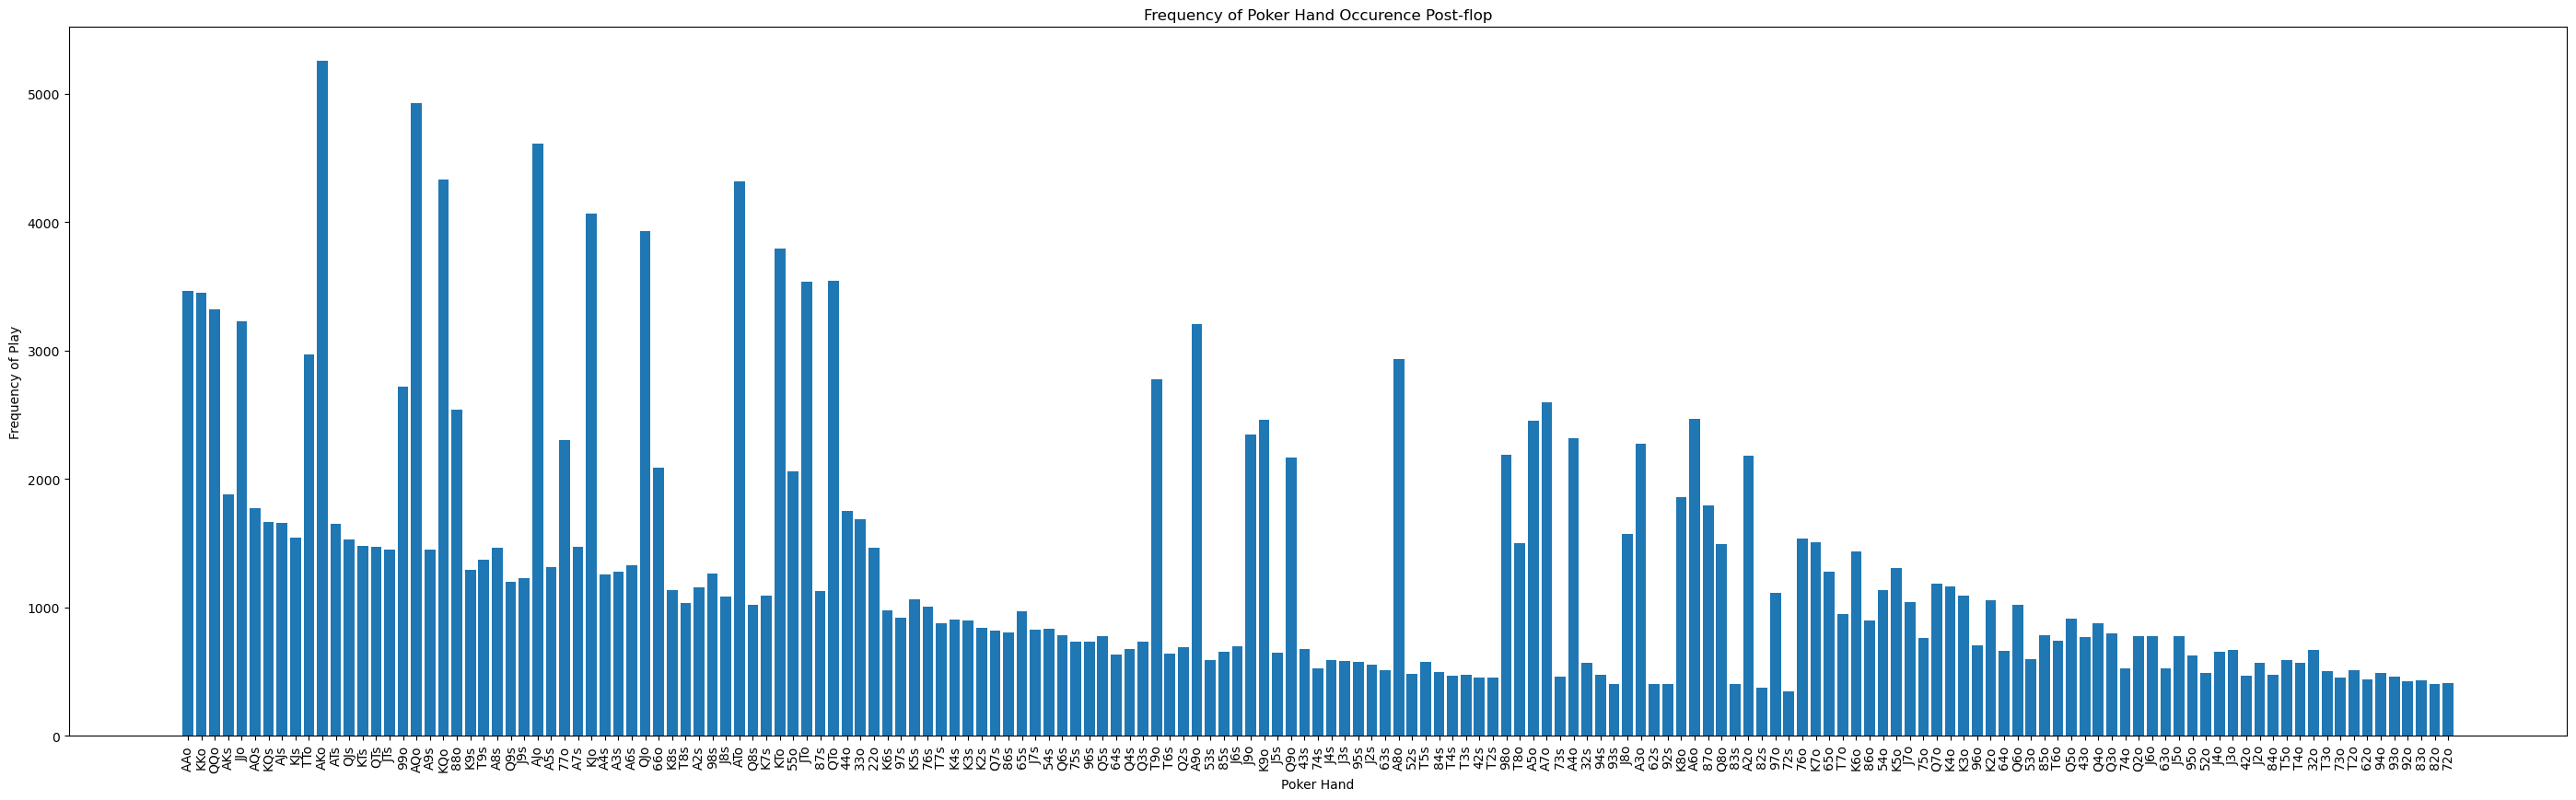

In [5]:
#hand_rankings
plt.figure(figsize = (35,10))
plt.tight_layout()

plt.bar(np.sort(df['preflop_rank'].dropna().unique()),df.groupby('preflop_rank').count()['index'])
plt.xticks(range(1,len(hand_rankings.keys())+1),hand_rankings.keys(), rotation = 'vertical')

plt.xlabel('Poker Hand')
plt.ylabel('Frequency of Play')
plt.title('Frequency of Poker Hand Occurence Post-flop')
plt.show()

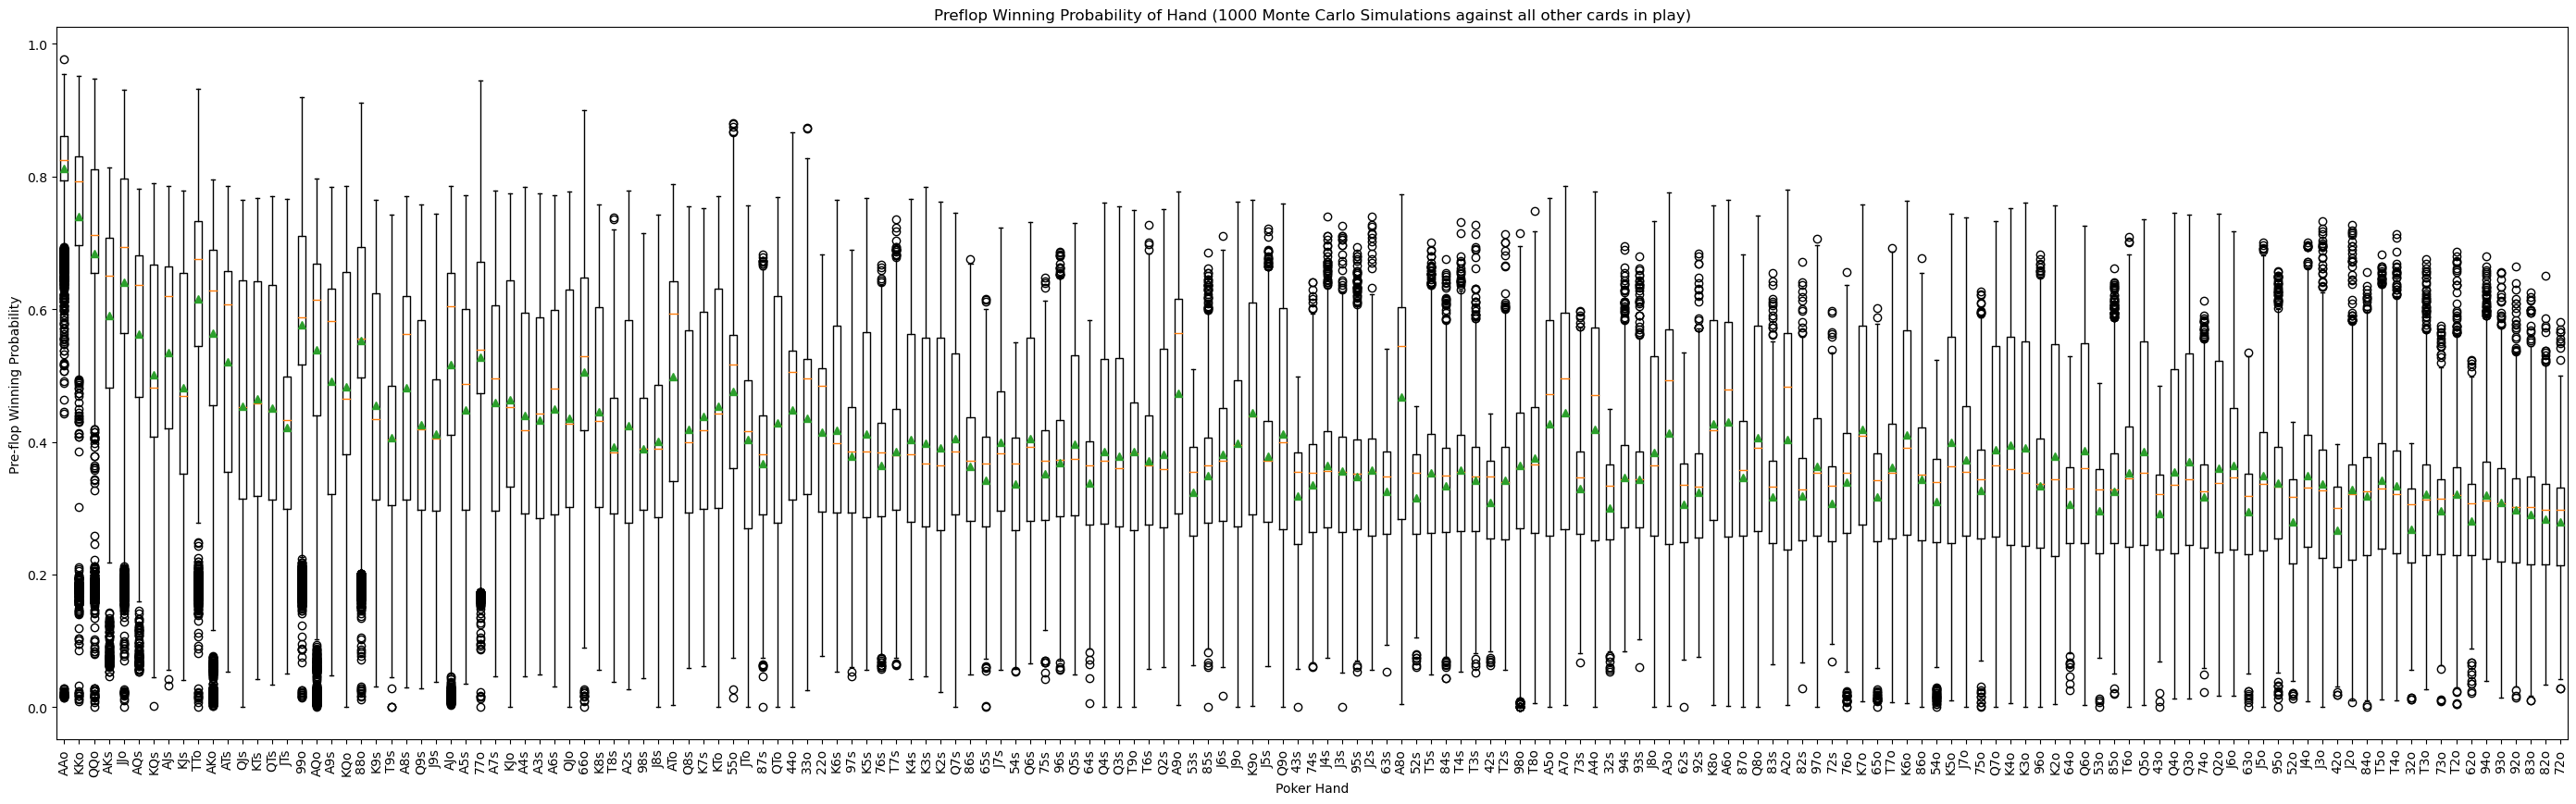

In [81]:
#boxplot
plt.figure(figsize = (35,10))
plt.tight_layout()

plt.boxplot(df.groupby('preflop_rank')['preflop_equity'].apply(list),showfliers=True,showmeans=True)
plt.xticks(range(1,len(hand_rankings.keys())+1),hand_rankings.keys(), rotation = 'vertical')

plt.xlabel('Poker Hand')
plt.ylabel('Pre-flop Winning Probability')
plt.title('Preflop Winning Probability of Hand (1000 Monte Carlo Simulations against all other cards in play)')
plt.show()

In [ ]:
#can additionally show how different people bet on the same type of hands

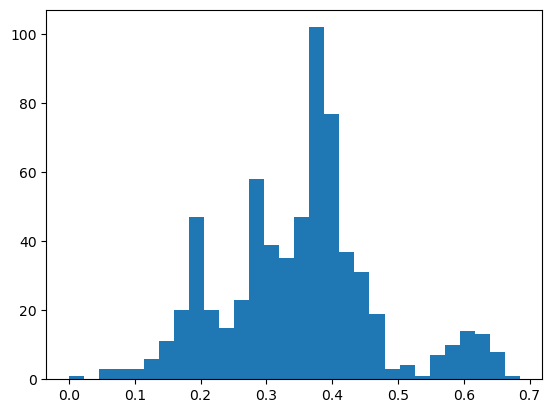

In [97]:
#histogram of Aces' probability
plt.hist(df.groupby('preflop_rank')['preflop_equity'].apply(list)[78.0],bins=30)
plt.show()

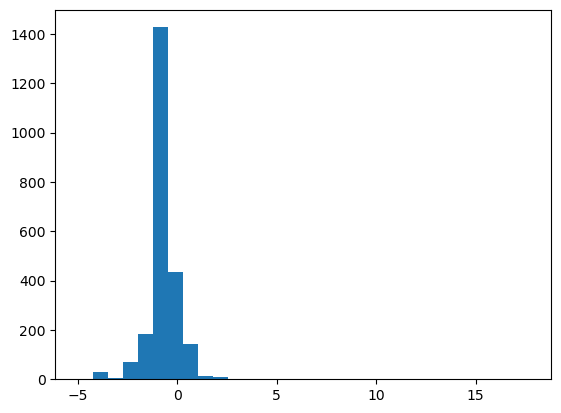

In [129]:
#barplot of mean preflop aggression across players
plt.hist(df.groupby('player')['preflop_cat_action'].mean(),bins=30)
plt.show()

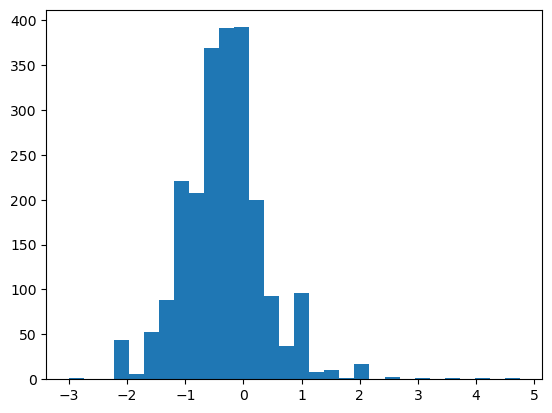

In [120]:
#barplot of mean flop aggression across players
#very interesting, all other stats quite spiked in the middle, but much more variance on mean flop aggression?
plt.hist(df.groupby('player')['flop_cat_action'].mean(),bins=30)
plt.show()

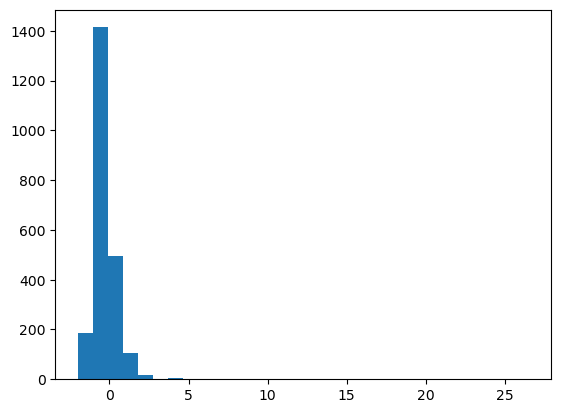

In [119]:
#barplot of turn flop aggression across players
plt.hist(df.groupby('player')['turn_cat_action'].mean(),bins=30)
plt.show()

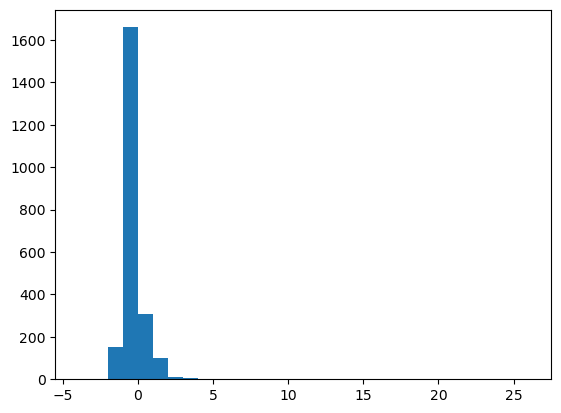

In [118]:
#barplot of river flop aggression across players
plt.hist(df.groupby('player')['river_cat_action'].mean(),bins=30)
plt.show()

<Axes: >

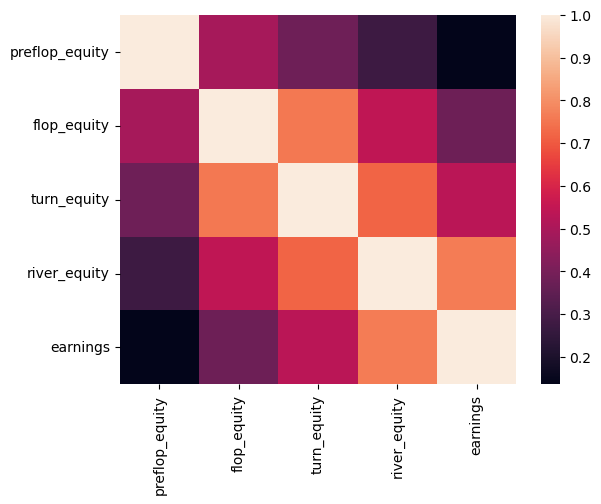

In [157]:
#how percentage to win the pot is directly correlated with final earnings
data = df[['preflop_equity','flop_equity','turn_equity','river_equity','earnings']].corr()
sns.heatmap(data)

<Axes: >

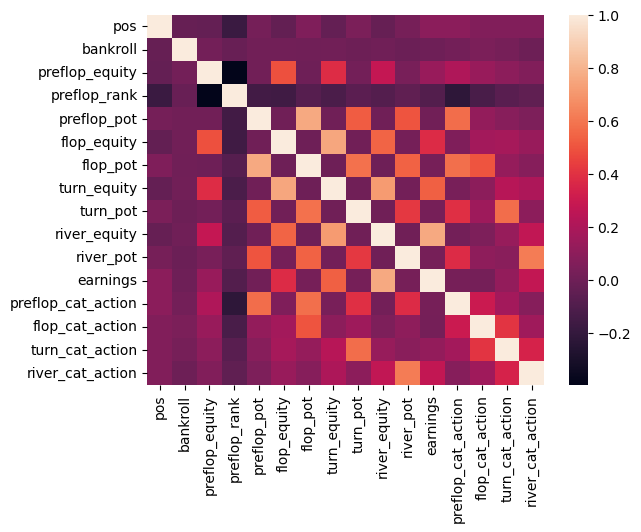

In [160]:
sns.heatmap(df[['pos','bankroll','preflop_equity','preflop_rank','preflop_pot','flop_equity','flop_pot','turn_equity',
               'turn_pot','river_equity','river_pot','earnings','preflop_cat_action','flop_cat_action','turn_cat_action',
               'river_cat_action']].corr())

Interesting things to note:
1. Position is relatively uncorrelated in general play to either aggression on all four streets and negatively correlated to the preflop rank of a particular hand
2. Bankroll seems to have no bearing on the particular decisions of players on a whole in individual hands (makes sense, as the game is a cash game, in tournament, this might drastically change where players apply ICM pressure)
3. Preflop equity seems to be relatively uncorrelated with preflop aggression, and this trend follows through the streets
4. Preflop hand rank seem to be negatively correlated (as expected) with action, as better hands would be acted upon through more aggressive betting

# Part 5. Modelling Part 1. Clustering

In [55]:
df

,index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,preflop_action,preflop_pot,...,turn_pot,river_equity,river_action,river_pot,earnings,pocket_cards,preflop_cat_action,flop_cat_action,turn_cat_action,river_cat_action
0,0,192,10,gunner,9,785,0.559,91.0,['c'],10.000000,...,20.0,1.0,['b'],20.0,60,"['8h', 'Ad']",-1,-1.0,-1.0,1.0
1,0,192,10,sagerbot,1,1740,0.402,35.0,"['B', 'k']",10.000000,...,20.0,0.0,"['k', 'c']",20.0,-60,"['Qd', 'Jc']",-1,1.0,1.0,-2.0
2,1,193,10,Winner777,3,1255,0.661,42.0,['r'],23.333333,...,20.0,1.0,"['b', 'c']",40.0,120,"['Td', 'Ac']",1,1.0,1.0,0.0
3,1,193,10,shinner,6,855,0.230,91.0,['c'],23.333333,...,20.0,0.0,['r'],40.0,-90,"['As', '8d']",-1,-1.0,-1.0,1.0
4,2,194,20,deadhead,6,1000,0.891,3.0,['r'],25.000000,...,20.0,1.0,['b'],20.0,80,"['Qd', 'Qc']",1,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360489,277605,31210,10,num,1,1810,NaN,NaN,"['B', 'f']",15.000000,...,NaN,NaN,NaN,NaN,-5,[],-2,NaN,NaN,NaN
360490,277606,31211,20,kman,1,21401,NaN,NaN,"['B', 'r']",30.000000,...,NaN,NaN,NaN,NaN,10,[],1,NaN,NaN,NaN
360491,277606,31211,20,num,2,1805,NaN,NaN,"['B', 'f']",30.000000,...,NaN,NaN,NaN,NaN,-10,[],-2,NaN,NaN,NaN
360492,277607,31212,10,kman,2,21411,NaN,NaN,['B'],15.000000,...,NaN,NaN,NaN,NaN,5,[],0,NaN,NaN,NaN


In [193]:
filtered_df = df.groupby('player').filter(lambda x:x['player'].count()>30)
filtered_df = filtered_df.groupby('player').mean()

C:\Users\AZhang\AppData\Local\Temp\ipykernel_1984\3128094283.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  filtered_df = filtered_df.groupby('player').mean()


In [200]:
#need to ensure that those who win the flop and make others fold are not punished
feature_df = filtered_df[['preflop_cat_action','preflop_rank']].fillna(0)
feature_df

,preflop_cat_action,preflop_rank
player,,
A8,-0.377251,64.395604
ABigLoser,-0.382353,66.800000
ACC,-0.610959,60.395000
ACESUP,-0.893478,50.888587
AIYAH,-0.438475,63.696721
...,...,...
zenith,-0.840000,82.600000
zippy,-0.990741,71.804124
zorbucks,-0.813953,55.968240


In [201]:
X_1 = preprocessing.StandardScaler().fit(feature_df).transform(feature_df)
print(X_1)

[[ 0.88889662 -0.09288684]
 [ 0.874724    0.08982468]
 [ 0.23965954 -0.39689526]
 ...
 [-0.32425684 -0.73328748]
 [-0.18428074 -0.77769655]
 [ 1.44082646 -0.34799821]]


In [202]:
kmeans1 = KMeans(n_clusters=4,n_init=20)
clust_1 = kmeans1.fit(X_1)
feature_df['clusters'] = clust_1.labels_
feature_df

C:\Users\AZhang\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,preflop_cat_action,preflop_rank,clusters
player,,,
A8,-0.377251,64.395604,0
ABigLoser,-0.382353,66.800000,0
ACC,-0.610959,60.395000,2
ACESUP,-0.893478,50.888587,2
AIYAH,-0.438475,63.696721,0
...,...,...,...
zenith,-0.840000,82.600000,1
zippy,-0.990741,71.804124,1
zorbucks,-0.813953,55.968240,2


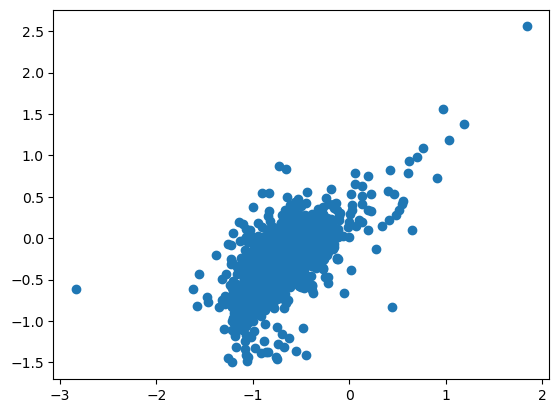

In [197]:
plt.scatter(filtered_df['preflop_cat_action'],filtered_df['flop_cat_action'])

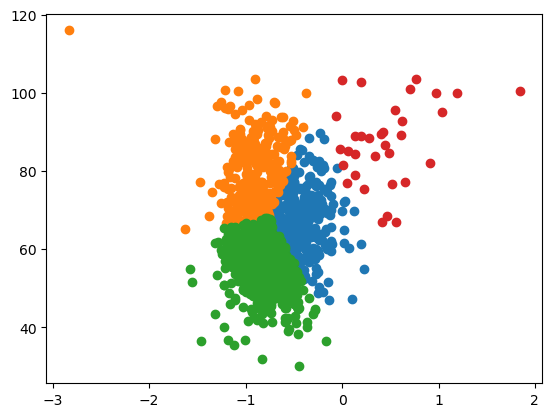

In [204]:
import matplotlib.pyplot as plt

for i in range(0,4):
    plt.scatter(feature_df.loc[feature_df['clusters'] == i, 'preflop_cat_action'],feature_df.loc[feature_df['clusters'] == i, 'preflop_rank'])

In [13]:
filtered_df

,index,hand_num,big_blind,pos,bankroll,preflop_equity,preflop_rank,preflop_pot,flop_equity,flop_pot,turn_equity,turn_pot,river_equity,river_pot,earnings,preflop_cat_action,flop_cat_action,turn_cat_action,river_cat_action
player,,,,,,,,,,,,,,,,,,,
A8,126220.412322,14977.767773,14.767773,2.329858,4422.308057,0.449154,64.395604,22.099447,0.468613,11.263736,0.491595,17.311355,0.483516,15.656724,12.429384,-0.377251,-0.295133,-0.541601,-0.510204
ACC,73605.682192,19176.049315,15.013699,2.854795,2610.545205,0.439385,60.395000,22.257893,0.427215,13.979167,0.425415,23.750000,0.430000,17.883333,6.967123,-0.610959,-0.040000,0.105000,-0.075000
ACESUP,51237.869565,16349.676087,14.652174,3.800000,1435.543478,0.464492,50.888587,19.224198,0.509278,12.575634,0.535025,19.760417,0.554348,15.906703,31.676087,-0.893478,-0.157609,-0.260870,-0.510870
AIYAH,170697.932409,10192.133449,13.934142,2.079723,905.045061,0.462680,63.696721,21.030040,0.437727,12.663934,0.433454,21.578552,0.426230,17.926230,3.930676,-0.438475,-0.237705,-0.336066,-0.483607
AIYAH^,273237.696296,26795.377778,13.851852,2.185185,1086.666667,0.466081,62.229730,21.759877,0.450167,14.707207,0.438509,17.837838,0.378378,17.162162,1.525926,-0.644444,-0.040541,-0.175676,-0.418919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xx,270571.123684,24107.807895,13.342105,2.250000,1461.931579,0.448807,70.589109,19.299781,0.444873,11.287129,0.430261,22.156766,0.450495,15.049505,4.344737,-0.815789,-0.318408,-0.243781,-0.422886
y,253584.214286,11114.087302,13.730159,4.460317,1514.103175,0.407342,59.158333,17.718915,0.417808,7.750000,0.451654,19.250000,0.441667,16.825000,40.269841,-0.841270,-1.375000,-0.966667,-0.766667
zippy,206869.268519,15022.796296,13.703704,3.481481,1320.787037,0.403722,71.804124,19.835648,0.387654,11.958763,0.391625,20.879725,0.329897,22.680412,4.425926,-0.990741,-0.618557,-0.608247,-0.402062


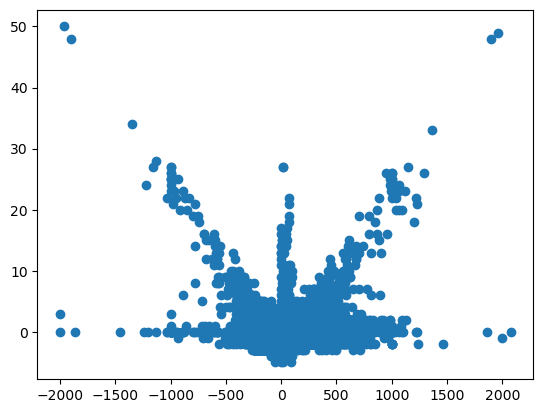

In [54]:
plt.scatter(df['earnings'],df['river_cat_action'])

In [47]:
from sklearn.linear_model import LinearRegression
    
#encode dummies

x = pd.get_dummies(feature_df['clusters']).iloc[:,1].array.reshape(-1,1)
y = filtered_df['earnings']

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

linreg = LinearRegression()
linreg.fit(x_train,y_train).score(x_test,y_test)


-0.0018370819985751297

In [302]:
num_clusters = []
cluster_var = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i,n_init=10)
    cluster = kmeans.fit(X_1)
    cluster_var.append(cluster.inertia_)
    num_clusters.append(i)

C:\Users\AZhang\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\AZhang\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\AZhang\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\AZhang\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: 

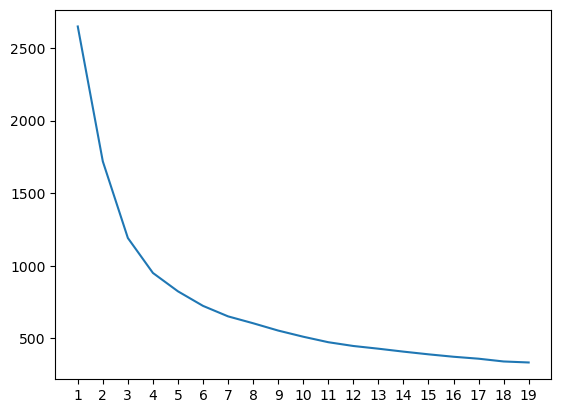

In [303]:
plt.plot(num_clusters,cluster_var)
plt.xticks(np.arange(1,20))
plt.show()

This seems to indicate that within-cluster variance is minimized at either k=2 or k=4, with k=4 being the more likely option. This agrees with the idea that 

In [233]:
print(cluster_var)

[907480.0000000364, 587691.3705551048, 478226.18883798557, 413185.8738463332, 347784.8917395085, 288297.8131236172, 262296.1653168372, 239493.6248653496, 218429.33300662824, 197401.0839310755, 182482.65755701455, 171755.43934053232, 162530.61386628912, 150652.97613980286, 144824.4054973134, 133971.51439428853, 126619.13705060507, 123056.6346404755, 115945.67123856148]


In [132]:
def tolist(one,two,three,four):

    actionlist = [one,two,three,four]
    actionlist = [i for i in actionlist if isinstance(i,str)]
    big_list = [[i[1:-1]] for i in actionlist]
    flattened_list = [i[1:-1] for i in actionlist]
        
    return big_list,flattened_list

df.apply(lambda x: tolist(x['preflop_action'], x['flop_action'],x['turn_action'],x['river_action'])[0], axis=1) 

0                   [['c'], ['c'], ['c'], ['b']]
1         [['B', 'k'], ['b'], ['b'], ['k', 'c']]
2              [['r'], ['b'], ['b'], ['b', 'c']]
3                   [['c'], ['c'], ['c'], ['r']]
4                   [['r'], ['b'], ['b'], ['b']]
                           ...                  
360489                              [['B', 'f']]
360490                              [['B', 'r']]
360491                              [['B', 'f']]
360492                                   [['B']]
360493                              [['B', 'f']]
Length: 360494, dtype: object

In [136]:
df

,index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,preflop_action,preflop_pot,...,turn_pot,river_equity,river_action,river_pot,earnings,pocket_cards,preflop_cat_action,flop_cat_action,turn_cat_action,river_cat_action
0,0,192,10,gunner,9,785,0.559,91.0,['c'],10.000000,...,20.0,1.0,['b'],20.0,60,"['8h', 'Ad']",-1,-1.0,-1.0,1.0
1,0,192,10,sagerbot,1,1740,0.402,35.0,"['B', 'k']",10.000000,...,20.0,0.0,"['k', 'c']",20.0,-60,"['Qd', 'Jc']",-1,1.0,1.0,-2.0
2,1,193,10,Winner777,3,1255,0.661,42.0,['r'],23.333333,...,20.0,1.0,"['b', 'c']",40.0,120,"['Td', 'Ac']",1,1.0,1.0,0.0
3,1,193,10,shinner,6,855,0.230,91.0,['c'],23.333333,...,20.0,0.0,['r'],40.0,-90,"['As', '8d']",-1,-1.0,-1.0,1.0
4,2,194,20,deadhead,6,1000,0.891,3.0,['r'],25.000000,...,20.0,1.0,['b'],20.0,80,"['Qd', 'Qc']",1,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360489,277605,31210,10,num,1,1810,NaN,NaN,"['B', 'f']",15.000000,...,NaN,NaN,NaN,NaN,-5,[],-2,NaN,NaN,NaN
360490,277606,31211,20,kman,1,21401,NaN,NaN,"['B', 'r']",30.000000,...,NaN,NaN,NaN,NaN,10,[],1,NaN,NaN,NaN
360491,277606,31211,20,num,2,1805,NaN,NaN,"['B', 'f']",30.000000,...,NaN,NaN,NaN,NaN,-10,[],-2,NaN,NaN,NaN
360492,277607,31212,10,kman,2,21411,NaN,NaN,['B'],15.000000,...,NaN,NaN,NaN,NaN,5,[],0,NaN,NaN,NaN


In [151]:
new_frame = df.groupby('index').count()['hand_num'].to_frame().copy()
new_frame.rename(columns={'hand_num':'num_players'},inplace=True)

result = pd.merge(df,new_frame, how='left',on=['index'])

In [152]:
result

,index,hand_num,big_blind,player,pos,bankroll,preflop_equity,preflop_rank,preflop_action,preflop_pot,...,river_equity,river_action,river_pot,earnings,pocket_cards,preflop_cat_action,flop_cat_action,turn_cat_action,river_cat_action,num_players
0,0,192,10,gunner,9,785,0.559,91.0,['c'],10.000000,...,1.0,['b'],20.0,60,"['8h', 'Ad']",-1,-1.0,-1.0,1.0,2
1,0,192,10,sagerbot,1,1740,0.402,35.0,"['B', 'k']",10.000000,...,0.0,"['k', 'c']",20.0,-60,"['Qd', 'Jc']",-1,1.0,1.0,-2.0,2
2,1,193,10,Winner777,3,1255,0.661,42.0,['r'],23.333333,...,1.0,"['b', 'c']",40.0,120,"['Td', 'Ac']",1,1.0,1.0,0.0,2
3,1,193,10,shinner,6,855,0.230,91.0,['c'],23.333333,...,0.0,['r'],40.0,-90,"['As', '8d']",-1,-1.0,-1.0,1.0,2
4,2,194,20,deadhead,6,1000,0.891,3.0,['r'],25.000000,...,1.0,['b'],20.0,80,"['Qd', 'Qc']",1,1.0,1.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360489,277605,31210,10,num,1,1810,NaN,NaN,"['B', 'f']",15.000000,...,NaN,NaN,NaN,-5,[],-2,NaN,NaN,NaN,2
360490,277606,31211,20,kman,1,21401,NaN,NaN,"['B', 'r']",30.000000,...,NaN,NaN,NaN,10,[],1,NaN,NaN,NaN,2
360491,277606,31211,20,num,2,1805,NaN,NaN,"['B', 'f']",30.000000,...,NaN,NaN,NaN,-10,[],-2,NaN,NaN,NaN,2
360492,277607,31212,10,kman,2,21411,NaN,NaN,['B'],15.000000,...,NaN,NaN,NaN,5,[],0,NaN,NaN,NaN,2


In [186]:
def tolist(one,two,three,four):

    actionlist = [one,two,three,four]
    actionlist = [i for i in actionlist if isinstance(i,str)]
    flattened_list = [i[1:-2].replace("'","") for i in actionlist]
    clean_list = [i.split(', ') for i in flattened_list]
    
    big_list = clean_list
    flat_list = [item for sublist in clean_list for item in sublist]
        
    return big_list, flat_list

df.apply(lambda x: tolist(x['preflop_action'], x['flop_action'],x['turn_action'],x['river_action']), axis=1)

0               [c, c, c, b]
1         [B, k, b, b, k, c]
2            [r, b, b, b, c]
3               [c, c, c, r]
4               [r, b, b, b]
                 ...        
360489                [B, f]
360490                [B, r]
360491                [B, f]
360492                   [B]
360493                [B, f]
Length: 360494, dtype: object

In [169]:
def aggression_factor(one,two,three,four):
    '''not true af, true af is bet+raise/calls'''
    actionlist = tolist(one,two,three,four)[1]
    total_len = len(actionlist)

    if actionlist[0] == 'B':
        total_len -= 1
        if total_len == 0:
            #no play, so no meaningful data; in the filtering process for modelling we will remove negative aggression
            return -1
    
    aggression_counter = 0
    aggression = ['b','r','A']
    
    for i in actionlist:
        if i in aggression:
            aggression_counter += 1

    return aggression_counter/total_len

df.apply(lambda x: aggression_factor(x['preflop_action'], x['flop_action'],x['turn_action'],x['river_action']), axis=1)

0         0.25
1         0.50
2         0.75
3         0.25
4         1.00
          ... 
360489    0.00
360490    0.00
360491    0.00
360492   -1.00
360493    0.00
Length: 360494, dtype: float64

In [172]:
def vpip(big_blind,earnings,preflop_pot,num_players,one,two,three,four):
    vpip = 0
    action_list = tolist(one,two,three,four)[0]
    if np.abs(earnings) < big_blind:
        vpip = 0
    elif np.abs(earnings) == big_blind:
        if action_list[0][-1] in exit_hand:
            vpip = 0
        else:
            vpip = ((preflop_pot-big_blind)*num_players)
    else:
        vpip = np.abs(earnings) - big_blind
        
    return vpip

['B', 'r']